In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), "../../"))
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from postgres import fetch_table,run_query

import logging


logging.basicConfig(level=logging.INFO)  # DEBUG < INFO < WARNING < ERROR < CRITICAL

pd.set_option("display.max_columns", None)  # Show all columns

In [2]:
# Fetch analytics tables from the mart
tracks_df = fetch_table("mart_all_tracks")
setlist_df = fetch_table("mart_setlist_history")
albums_df = fetch_table("mart_all_albums")
track_setlist_df = fetch_table("mart_track_setlist_similarity_scores")

In [3]:
# fetch combined table with filtering of albums not relevant and 

query="""
with track_link_cte as (
	select 
 		sim.event_set_song_id
 		,sim.track_id
 		,row_number() over (partition by sim.event_set_song_id order by similarity_score desc nulls last) as similarity_rank_post_filter
	 from 
	 	analytics_mart.mart_track_setlist_similarity_scores as sim 
	 	join analytics_mart.mart_all_tracks as all_tr
	 		on sim.track_id = all_tr.track_id
	 where true
	 	and all_tr.album_id not in ('4bGIhBIGsziCakPziupVmQ','39P5R1B5XF1dGhpojrukVA','06y12naBReESEe7u2OFG7j')
)
, track_link_filtered_cte as (
	select 
 		*
	 from 
	 	track_link_cte
	 where true
	 	and similarity_rank_post_filter = 1
)
select 
	msh.*
	,tr.*
from 
	analytics_mart.mart_setlist_history as msh
	left join track_link_filtered_cte as tl_cte
		on msh.event_set_song_id = tl_cte.event_set_song_id
	left join analytics_mart.mart_all_tracks as tr
		on tl_cte.track_id = tr.track_id
where true
"""

df = run_query(query)

df.head(5)

,event_set_song_id,event_id,event_date,event_info,event_url,event_tour_id,event_tour,venue_id,venue_name,venue_city,venue_state_code,venue_country_code,venue_latitude,venue_longitude,set_index,encore_index,encore_flag,song_index,song_position_in_set_index,song_name,song_info,song_cover_flag,song_cover_artist_mbid,song_cover_artist_name,song_with_flag,song_with_artist_mbid,song_with_artist_name,song_last_event_set_song_id,song_last_event_id,song_last_event_date,album_id,album_url,album_uri,album_type,album_name,album_total_tracks,album_release_date,album_image_url,album_popularity,track_id,track_url,track_uri,track_disk_number,track_duration_seconds,track_name,track_number,track_popularity,track_irsc
0,f70b46c63158512acfd0e9e380740936,23b3c037,2022-08-19,"""The End of the End: The Final 'Farewell' - Ni...",https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,3ead6808346232b1f2dbb4766ac13970,The Fillmore Philadelphia,Philadelphia,PA,US,39.952335,-75.163789,6,0,False,10,6,"2,459 Miles",None,False,None,None,False,None,None,None,None,None,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118
1,ea5b86c521af0a538bfdca76826c843f,bb20d3e,2022-07-31,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,67033f6c6025699f9b736b49526d9202,Baltimore Soundstage,Baltimore,MD,US,39.290385,-76.612189,16,0,False,20,16,"2,459 Miles",None,False,None,None,False,None,None,8447b29530c0cd0159da8e05a101a96c,4bb26346,2022-08-04,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118
2,cc4e377e01cfdf85fa8740343080da65,23b2e02b,2022-07-23,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,1dcc14e22e3a035018cfbbc01a1b8cbe,Anthology,Rochester,NY,US,43.154784,-77.615557,13,0,False,18,13,"2,459 Miles",None,False,None,None,False,None,None,d29094f452096bd3b1e376d1de2f4600,1bb2397c,2022-07-27,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118
3,0a2eac66c928dcef788b28475b42bbed,23b590ff,2022-06-26,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,83e427da4adbebb552bafbb4d88bc69b,South Side Music Hall,Dallas,TX,US,32.783056,-96.806667,15,0,False,19,15,"2,459 Miles",None,False,None,None,False,None,None,d33984f4b9070f8fb7d7d1d9d4630ce1,7bb5fad0,2022-06-29,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118
4,d53e8da428f125279096a254a4df3b76,4bb44352,2022-06-21,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,512398586657e67f861f9f54f02a20d8,Beacham Theatre,Orlando,FL,US,28.538335,-81.379237,1,0,False,1,1,"2,459 Miles",None,False,None,None,False,None,None,0a2eac66c928dcef788b28475b42bbed,23b590ff,2022-06-26,0wFPFHvi467fdOlBKTVJRY,https://api.spo

In [6]:
print(df['event_date'].dtype)

object


In [12]:
df.event_id.nunique()

905

In [13]:
df.event_date.min()

datetime.date(2000, 1, 1)

In [16]:
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')

df['year'] = df['event_date'].dt.year

event_counts = df.groupby('year')['event_url'].nunique()

event_counts

year
2000     1
2001     3
2002     6
2003    11
2004    12
2005    17
2006    33
2007    54
2008    27
2009    43
2010    41
2011    28
2012    64
2013    43
2014    59
2015    88
2016    98
2017    88
2018    49
2019    44
2020    28
2021    12
2022    56
Name: event_url, dtype: int64

<Axes: title={'center': 'Unique Events per Year'}, xlabel='year'>

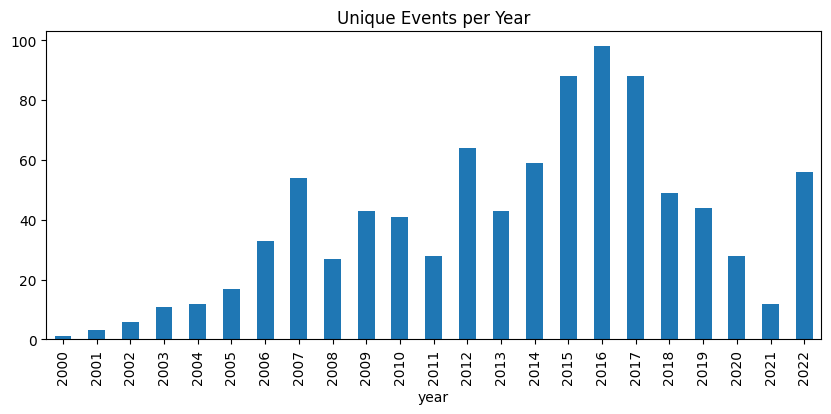

In [17]:
event_counts.plot(kind='bar', title='Unique Events per Year', figsize=(10, 4))

In [18]:
df['song_name'].value_counts()

song_name
In a Sweater Poorly Knit             462
January 1979                         348
Messes of Men                        325
Red Cow                              325
Torches Together                     307
                                    ... 
America                                1
Away in a Manger                       1
Come Thou Fount of Every Blessing      1
Oh Comely                              1
You've Got to Hide Your Love Away      1
Name: count, Length: 147, dtype: int64

In [19]:
df_recent = df[df.event_date >= '2019-01-01'].reset_index(drop=True)

df_recent

,event_set_song_id,event_id,event_date,event_info,event_url,event_tour_id,event_tour,venue_id,venue_name,venue_city,venue_state_code,venue_country_code,venue_latitude,venue_longitude,set_index,encore_index,encore_flag,song_index,song_position_in_set_index,song_name,song_info,song_cover_flag,song_cover_artist_mbid,song_cover_artist_name,song_with_flag,song_with_artist_mbid,song_with_artist_name,song_last_event_set_song_id,song_last_event_id,song_last_event_date,album_id,album_url,album_uri,album_type,album_name,album_total_tracks,album_release_date,album_image_url,album_popularity,track_id,track_url,track_uri,track_disk_number,track_duration_seconds,track_name,track_number,track_popularity,track_irsc,year
0,f70b46c63158512acfd0e9e380740936,23b3c037,2022-08-19,"""The End of the End: The Final 'Farewell' - Ni...",https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,3ead6808346232b1f2dbb4766ac13970,The Fillmore Philadelphia,Philadelphia,PA,US,39.952335,-75.163789,6,0,False,10,6,"2,459 Miles",None,False,None,None,False,None,None,None,None,None,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118,2022
1,ea5b86c521af0a538bfdca76826c843f,bb20d3e,2022-07-31,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,67033f6c6025699f9b736b49526d9202,Baltimore Soundstage,Baltimore,MD,US,39.290385,-76.612189,16,0,False,20,16,"2,459 Miles",None,False,None,None,False,None,None,8447b29530c0cd0159da8e05a101a96c,4bb26346,2022-08-04,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118,2022
2,cc4e377e01cfdf85fa8740343080da65,23b2e02b,2022-07-23,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,1dcc14e22e3a035018cfbbc01a1b8cbe,Anthology,Rochester,NY,US,43.154784,-77.615557,13,0,False,18,13,"2,459 Miles",None,False,None,None,False,None,None,d29094f452096bd3b1e376d1de2f4600,1bb2397c,2022-07-27,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118,2022
3,0a2eac66c928dcef788b28475b42bbed,23b590ff,2022-06-26,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,83e427da4adbebb552bafbb4d88bc69b,South Side Music Hall,Dallas,TX,US,32.783056,-96.806667,15,0,False,19,15,"2,459 Miles",None,False,None,None,False,None,None,d33984f4b9070f8fb7d7d1d9d4630ce1,7bb5fad0,2022-06-29,0wFPFHvi467fdOlBKTVJRY,https://api.spotify.com/v1/albums/0wFPFHvi467f...,spotify:album:0wFPFHvi467fdOlBKTVJRY,album,[Untitled],12.0,2018-10-05,https://i.scdn.co/image/ab67616d0000b273ca3cdf...,30.0,0Zszl40tff7RJrH87kFlGo,https://api.spotify.com/v1/tracks/0Zszl40tff7R...,spotify:track:0Zszl40tff7RJrH87kFlGo,1.0,146.0,"2,459 Miles",8.0,18.0,QMCE71302118,2022
4,d53e8da428f125279096a254a4df3b76,4bb44352,2022-06-21,None,https://www.setlist.fm/setlist/mewithoutyou/20...,461b0e99dcabe69f95468ad8d149b96b,Farewell Tour,512398586657e67f861f9f54f02a20d8,Beacham Theatre,Orlando,FL,US,28.538335,-81.379237,1,0,False,1,1,"2,459 Miles",None,False,None,None,False,None,None,0a2eac66c928dcef788b28475b42bbed,23b590ff,2022-06-26,0wFPFHvi467fd

In [20]:
df_recent['covid_era'] = df_recent['event_date'].apply(
    lambda d: 'pre' if d < pd.Timestamp('2020-03-01') else 'post'
)

song_counts = (
    df_recent
    .groupby(['covid_era', 'song_name'])
    .size()
    .reset_index(name='count')
)

# Normalize by total shows per era (since they likely did fewer shows post-2020)
total_shows = df_recent.groupby('covid_era')['event_date'].nunique().to_dict()

song_counts['per_show'] = song_counts.apply(
    lambda row: row['count'] / total_shows[row['covid_era']], axis=1
)

In [21]:
# Pivot table to see differences
pivot = song_counts.pivot(index='song_name', columns='covid_era', values='per_show').fillna(0)

# Add a column for difference
pivot['change'] = pivot['post'] - pivot['pre']

# See most increased/decreased songs
pivot.sort_values('change', ascending=False).head(10)  # Most more-played post-COVID
pivot.sort_values('change').head(10)                   # Most dropped post-COVID

covid_era,post,pre,change
song_name,,,
"Flee, Thou Matadors!",0.117647,0.416667,-0.299020
Tortoises All the Way Down,0.161765,0.416667,-0.254902
"New Wine, New Skins",0.205882,0.444444,-0.238562
Another Head for Hydra,0.264706,0.500000,-0.235294
Watermelon Ascot,0.132353,0.277778,-0.145425
"9:27a.m., 7/29",0.411765,0.555556,-0.143791
"Julia (or, 'Holy to the LORD' on the Bells of Horses)",0.867647,0.972222,-0.104575
Grist for the Malady Mill,0.205882,0.291667,-0.085784
Red Cow,0.441176,0.513889,-0.072712


<Axes: ylabel='song_name'>

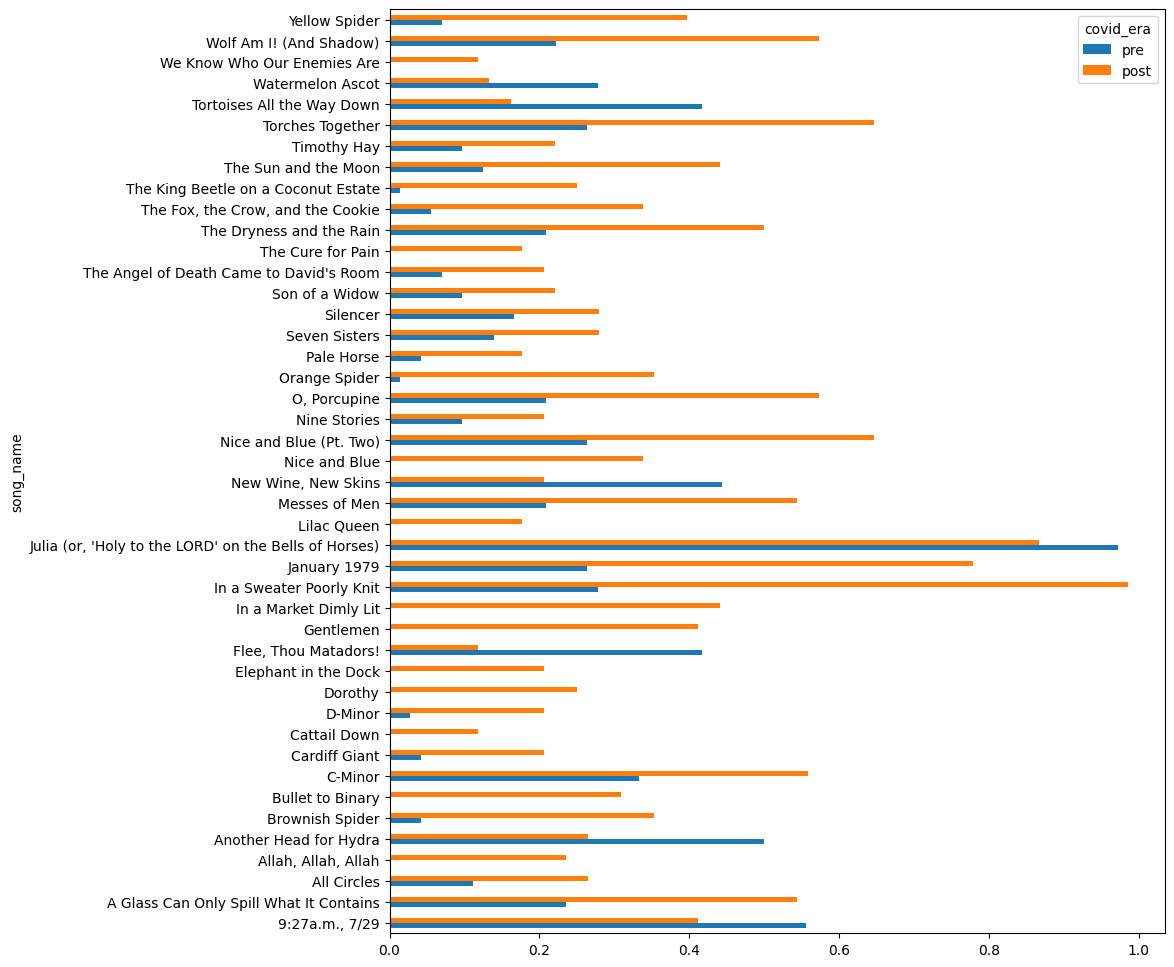

In [22]:
pivot.loc[pivot['change'].abs() > 0.1][['pre', 'post']].plot(kind='barh', figsize=(10, 12))

In [9]:
query_song_prob="""
with track_link_cte as (
	select 
 		sim.event_set_song_id
 		,sim.track_id
 		,row_number() over (partition by sim.event_set_song_id order by similarity_score desc nulls last) as similarity_rank_post_filter
	 from 
	 	analytics_mart.mart_track_setlist_similarity_scores as sim 
	 	join analytics_mart.mart_all_tracks as all_tr
	 		on sim.track_id = all_tr.track_id
	 where true
	 	and all_tr.album_id not in ('4bGIhBIGsziCakPziupVmQ','39P5R1B5XF1dGhpojrukVA','06y12naBReESEe7u2OFG7j')
)
, track_link_filtered_cte as (
	select 
 		*
	 from 
	 	track_link_cte
	 where true
	 	and similarity_rank_post_filter = 1
)
, setlist_clean_cte as (
	select 
		msh.*
		,tr.*
	from 
		analytics_mart.mart_setlist_history as msh
		left join track_link_filtered_cte as tl_cte
			on msh.event_set_song_id = tl_cte.event_set_song_id
		left join analytics_mart.mart_all_tracks as tr
			on tl_cte.track_id = tr.track_id
	where true
)
, events_per_tour as (
	select 
		event_tour_id
		,count(distinct event_id) as total_events
	from 
		setlist_clean_cte 
	group by 
		1
)
select 
	st.event_tour_id
	,st.song_name
    ,st.event_tour
	,count(distinct st.event_id) as total_times_played
	,max(tour.total_events) as total_chances_to_play
	,(count(distinct st.event_id)*1.00) / max(tour.total_events) as song_probability_in_tour
from 
	setlist_clean_cte as st
	join events_per_tour as tour
		on st.event_tour_id = tour.event_tour_id
where true 
group by 
	1,2,3
;
"""

song_tour_prob_df = run_query(query_song_prob)

song_tour_prob_df.head(5)

,event_tour_id,song_name,event_tour,total_times_played,total_chances_to_play,song_probability_in_tour
0,138c363d322d3177de2d3c6c17327949,A Glass Can Only Spill What It Contains,Shirts for a Cure,1,3,0.333333
1,138c363d322d3177de2d3c6c17327949,Disaster Tourism,Shirts for a Cure,2,3,0.666667
2,138c363d322d3177de2d3c6c17327949,Four Word Letter (Pt. Two),Shirts for a Cure,3,3,1.000000
3,138c363d322d3177de2d3c6c17327949,In a Sweater Poorly Knit,Shirts for a Cure,2,3,0.666667
4,138c363d322d3177de2d3c6c17327949,January 1979,Shirts for a Cure,3,3,1.000000


In [16]:
from scipy.stats import entropy


song_tour_prob_df['norm_prob'] = song_tour_prob_df.groupby('event_tour_id')['song_probability_in_tour'].transform(lambda x: x / x.sum())

# Define a helper function
def calculate_entropy(group):
    probs = group['norm_prob'].values
    return pd.Series({'entropy': entropy(probs, base=2)})

entropy_by_tour = song_tour_prob_df.groupby('event_tour_id').apply(calculate_entropy).reset_index()

entropy_by_tour.head(30)

/var/folders/jx/c2qzc0q55l5f5np5j5nzwtxh0000gn/T/ipykernel_60746/399591431.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_by_tour = song_tour_prob_df.groupby('event_tour_id').apply(calculate_entropy).reset_index()


,event_tour_id,entropy
0,138c363d322d3177de2d3c6c17327949,3.661226
1,1c9a5be4c5168b93438b686a2f807747,5.364526
2,1d5f9aa8e9305567374393d22c522082,3.901427
3,21a6ba826e18ba4fb17e1ab999e78139,4.271992
4,2ae66dcde53c05d46b22b3eb5af14875,4.943805
5,2c6d36c640f2529d74825794bcb3c9eb,3.908542
6,3d2db00c7e54f44a18e41fed074a9e2c,3.468017
7,461b0e99dcabe69f95468ad8d149b96b,6.036397
8,4893704f23fd39679c997d590395ba82,3.699473
9,4a743d3a512d8d2eb5f6399f76c16535,4.751966


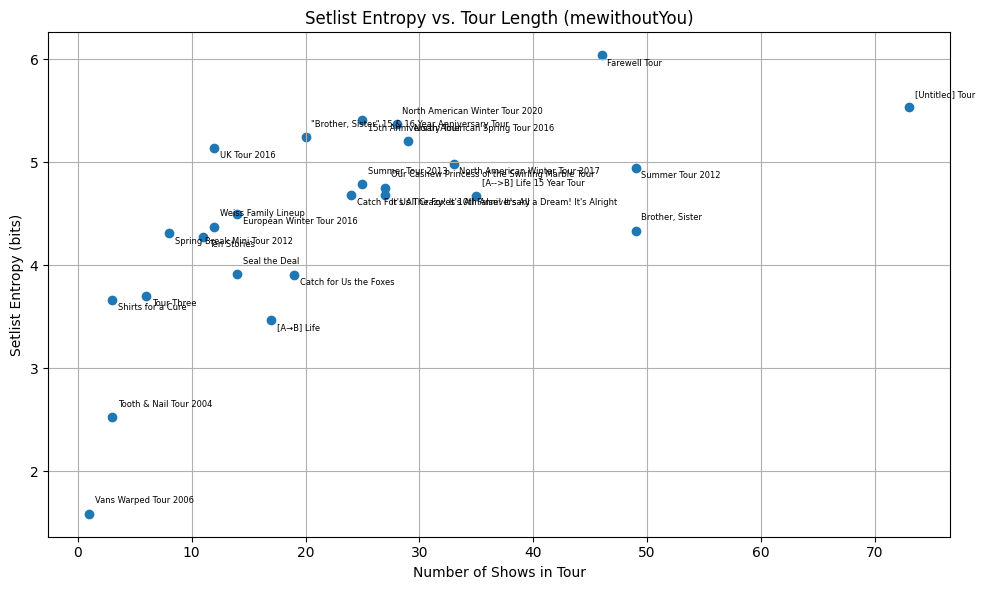

In [30]:
import numpy as np

entropy_shows = (
    song_tour_prob_df
    .merge(entropy_by_tour, on="event_tour_id")
    .groupby(['event_tour_id', 'event_tour'])[['total_chances_to_play', 'entropy']]
    .max()
    .reset_index()
)


plt.figure(figsize=(10, 6))
plt.scatter(entropy_shows['total_chances_to_play'], entropy_shows['entropy'])

np.random.seed(42)

for _, row in entropy_shows.iterrows():
    y_offset = np.random.choice([-0.1, 0.1])
    if row['entropy'] > 4.5 or row['entropy'] < 4.5:  # label outliers
        plt.text(
            row['total_chances_to_play'] + 0.5
            , row['entropy'] + y_offset
            , row['event_tour']
            , fontsize=6)

plt.xlabel("Number of Shows in Tour")
plt.ylabel("Setlist Entropy (bits)")
plt.title("Setlist Entropy vs. Tour Length (mewithoutYou)")
plt.grid(True)
plt.tight_layout()
plt.show()

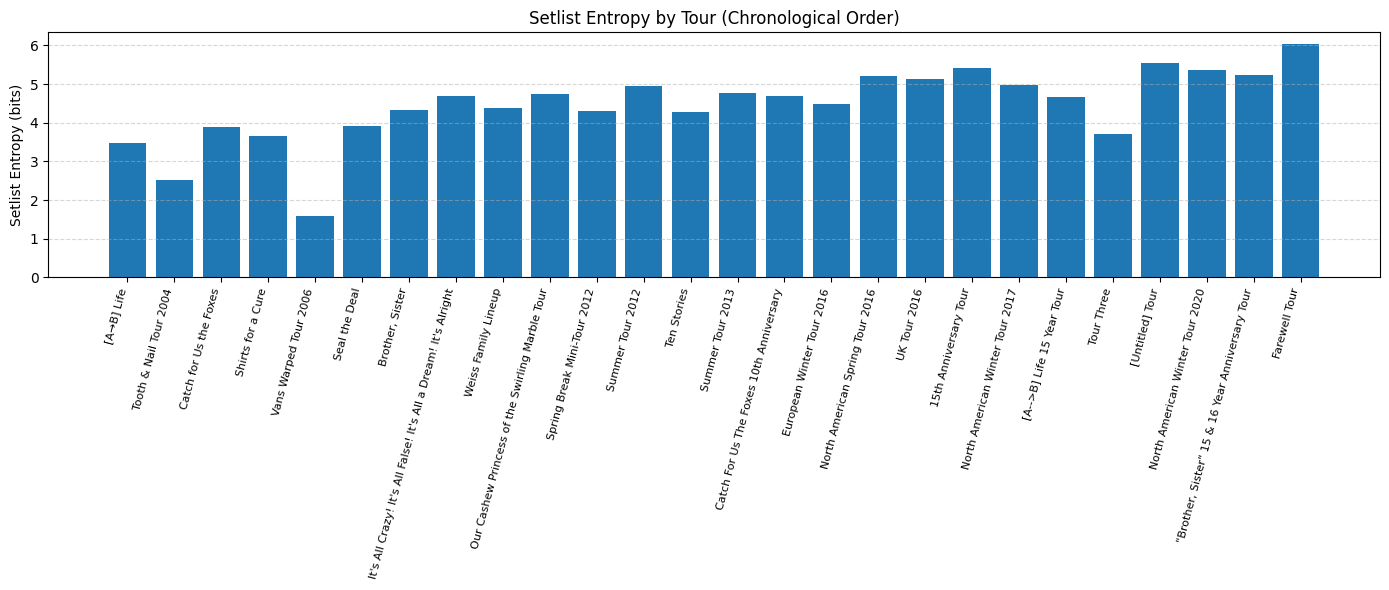

In [39]:
tours_df = (
    df.groupby('event_tour_id')['event_date']
    .min()
    .reset_index()
    )

tours_df = tours_df.merge(entropy_shows, on='event_tour_id')

tours_df['effective_setlist_size']= 2 ** tours_df['entropy']

tours_df_sorted = tours_df.sort_values('event_date').reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.bar(tours_df_sorted['event_tour'], tours_df_sorted['entropy'])

plt.xticks(rotation=75, ha='right', fontsize=8)
plt.ylabel("Setlist Entropy (bits)")
plt.title("Setlist Entropy by Tour (Chronological Order)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

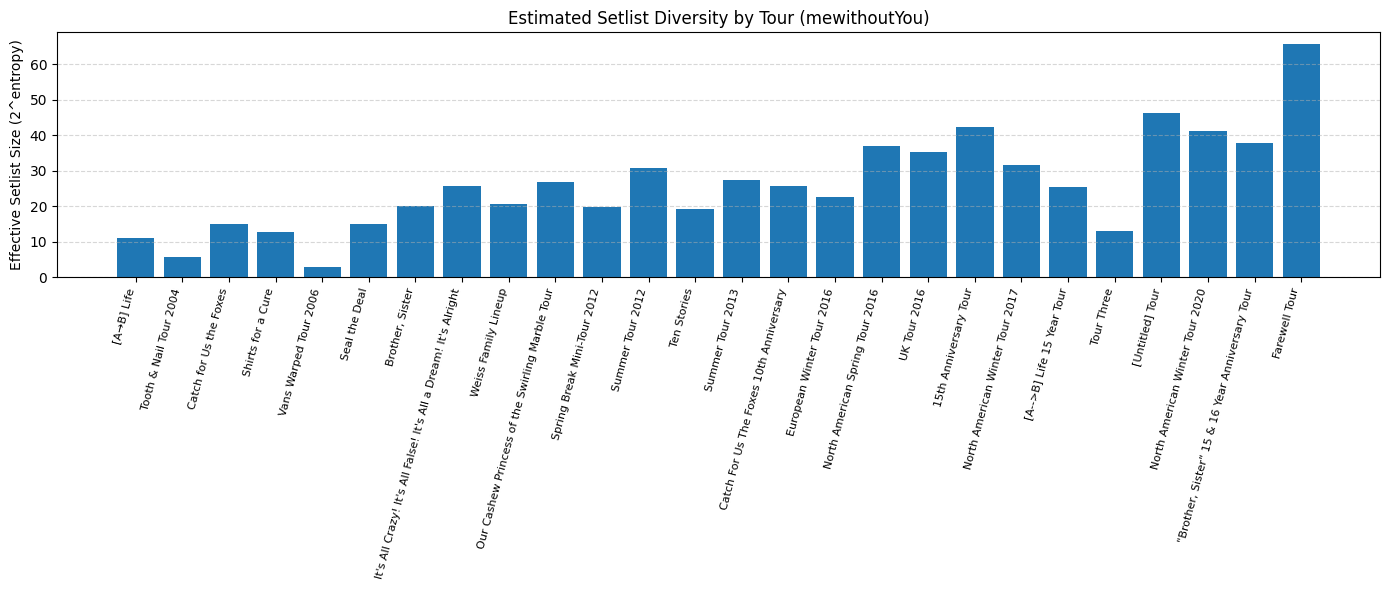

In [40]:
plt.figure(figsize=(14, 6))
plt.bar(tours_df_sorted['event_tour'], tours_df_sorted['effective_setlist_size'])

plt.xticks(rotation=75, ha='right', fontsize=8)
plt.ylabel("Effective Setlist Size (2^entropy)")
plt.title("Estimated Setlist Diversity by Tour (mewithoutYou)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()